# Bird Sound Classification: MP3 to Spectrogram and Prediction

This notebook preprocesses MP3 bird audio files into normalized spectrograms using the Short-Time Fourier Transform (STFT) and predicts species using a convolutional neural network (CNN).  
STFT-based spectrograms capture the time-frequency patterns essential for distinguishing bird calls, and CNNs are highly effective for classifying such structured data.


## 1. Setup and Configuration

Import libraries and define parameters for audio processing and model architecture.  
Consistent configuration ensures reproducible and reliable results.


In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow.keras import layers, models

SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LENGTH = 512
TARGET_FREQ = 343
TARGET_TIME = 256
INPUT_SHAPE = (TARGET_FREQ, TARGET_TIME, 1)
TEST_DIR = "../data/external_test_clips"
OUTPUT_HDF5 = "../data/external_test_processed.hdf5"
MODEL_WEIGHTS = "../models/multiclass_weights.weights.h5"


## 2. MP3 to Normalized Spectrogram Conversion

Each MP3 file is converted to a normalized spectrogram using STFT, decibel scaling, resizing, and normalization to [-1, 1].  
This process produces consistent, information-rich inputs for the neural network.


In [2]:
def mp3_to_spectrogram(file_path):
    y, _ = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    S_fixed = librosa.util.fix_length(S_db, size=TARGET_TIME, axis=1)
    S_fixed = S_fixed[:TARGET_FREQ, :]
    S_norm = (S_fixed - S_fixed.min()) / (S_fixed.ptp()) * 2 - 1
    return S_norm[..., np.newaxis]  # Add channel dimension


## 3. Process and Preview Test Audio Files

All test MP3 files are converted to spectrograms, previewed for visual inspection, and saved to an HDF5 file.  
Previewing ensures the preprocessing is correct and helps catch errors early.


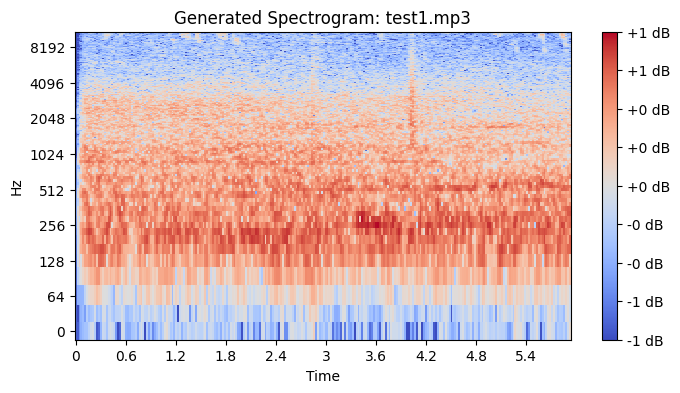

Processed: test1.mp3


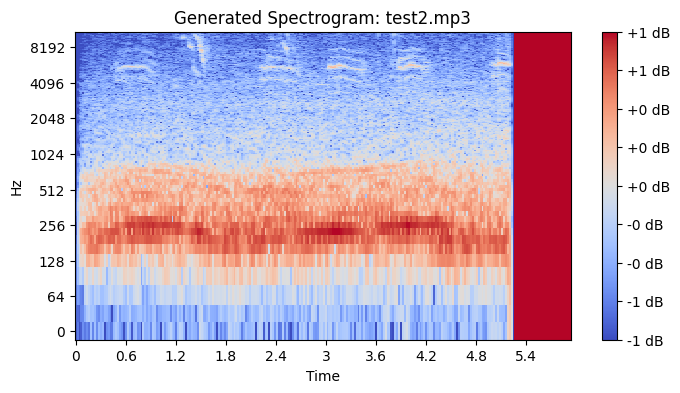

Processed: test2.mp3


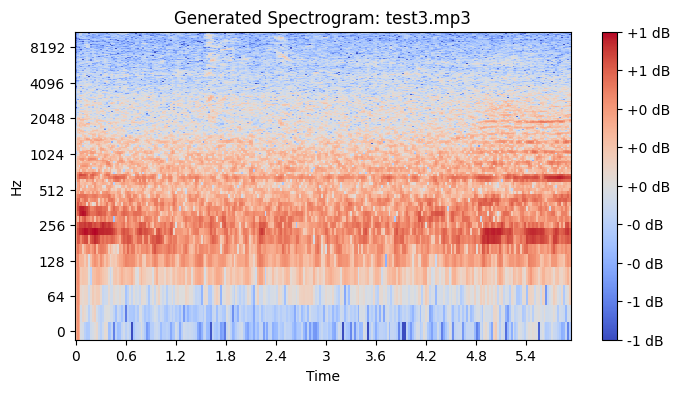

Processed: test3.mp3

Saved 3 spectrograms to ../data/external_test_processed.hdf5


In [3]:
spectrograms = []
filenames = []

for fname in sorted(os.listdir(TEST_DIR)):
    if fname.lower().endswith('.mp3'):
        try:
            spec = mp3_to_spectrogram(os.path.join(TEST_DIR, fname))
            spectrograms.append(spec)
            filenames.append(fname)
            
            # Preview the spectrogram after creation
            plt.figure(figsize=(8, 4))
            librosa.display.specshow(spec[..., 0], sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
                              x_axis='time', y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Generated Spectrogram: {fname}")
            plt.show()
            
            print(f"Processed: {fname}")
        except Exception as e:
            print(f"Error processing {fname}: {e}")

spectrograms = np.array(spectrograms)
with h5py.File(OUTPUT_HDF5, 'w') as hf:
    hf.create_dataset('X_test', data=spectrograms)
    hf.create_dataset('filenames', data=np.array(filenames, dtype=h5py.string_dtype()))
print(f"\nSaved {len(spectrograms)} spectrograms to {OUTPUT_HDF5}")


## 4. Model Definition and Weights Loading

The CNN model is rebuilt exactly as during training and pre-trained weights are loaded.  
This ensures compatibility and reliable inference.


In [4]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(12, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.load_weights(MODEL_WEIGHTS)
model.summary()


c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 343, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 171, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 171, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 85, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,732 (432.55 KB)

 Trainable params: 110,732 (432.55 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Predict Species for Test Audio Files

The model predicts the bird species for each test file, printing the predicted label and confidence.  
This provides a clear, auditable record of model predictions for each sample.


In [5]:
with h5py.File(OUTPUT_HDF5, 'r') as hf:
    X_test = hf['X_test'][:]
    filenames = hf['filenames'][:]

species_labels = [
    'amecro','amerob','bewwre','bkcchi','daejun','houfin',
    'houspa','norfli','rewbla','sonspa','spotow','whcspa'
]

probs = model.predict(X_test)
preds = np.argmax(probs, axis=1)

for fname, pred_idx, confidence in zip(filenames, preds, np.max(probs, axis=1)):
    print(f"{fname}: {species_labels[pred_idx]} (confidence: {confidence:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
b'test1.mp3': houspa (confidence: 0.90)
b'test2.mp3': houspa (confidence: 0.80)
b'test3.mp3': houspa (confidence: 0.91)


## 6. Visualize Predictions with Probability Values

For each test file, the spectrogram and a horizontal bar plot of predicted probabilities are shown.  
This visualization helps interpret the model’s decision process and confidence in its predictions.


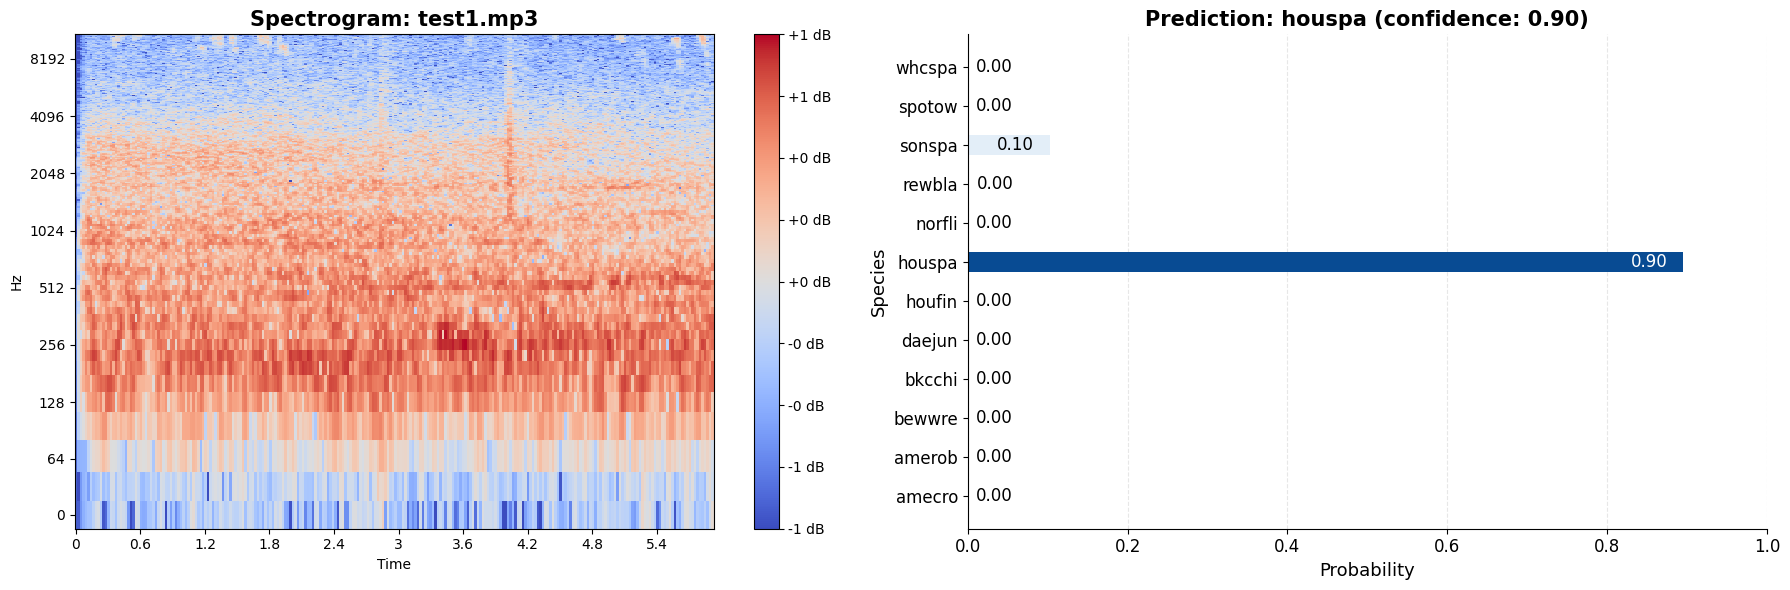

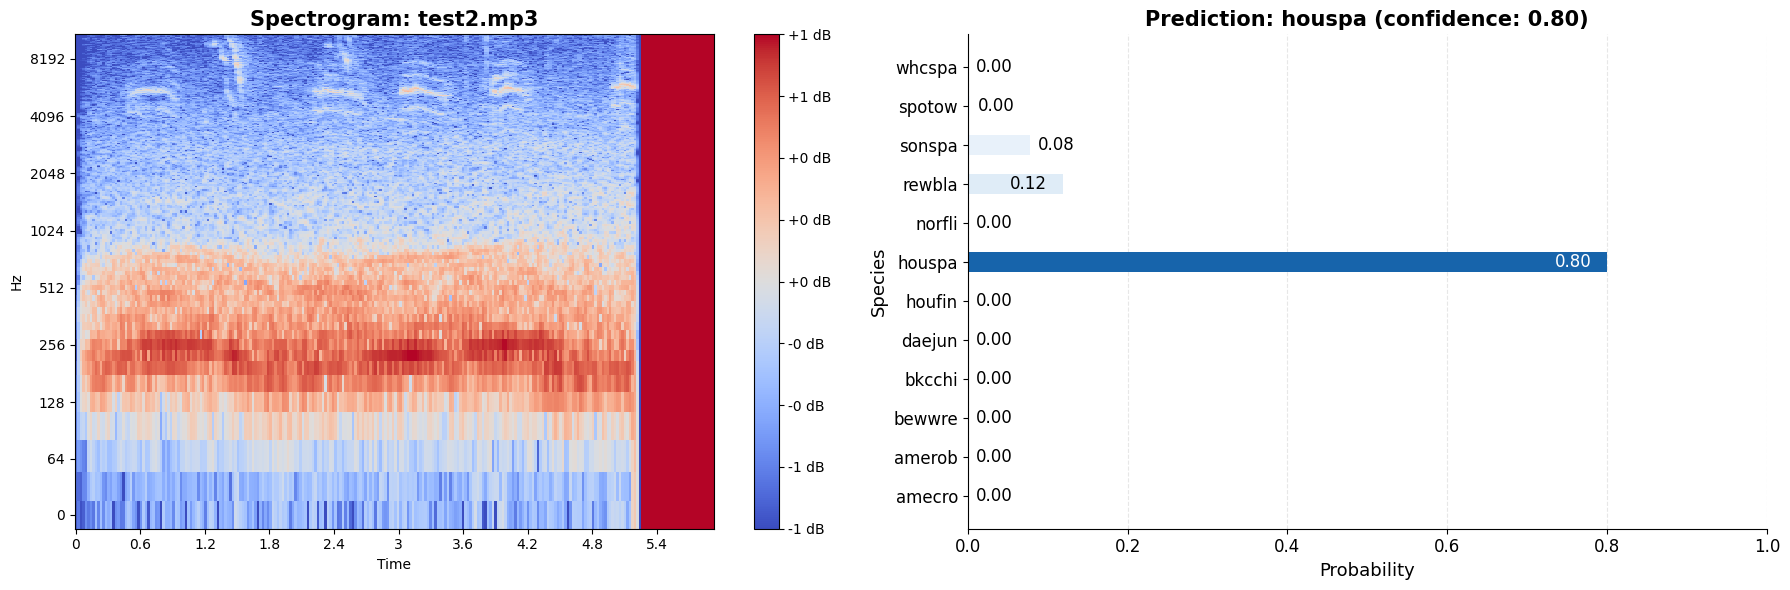

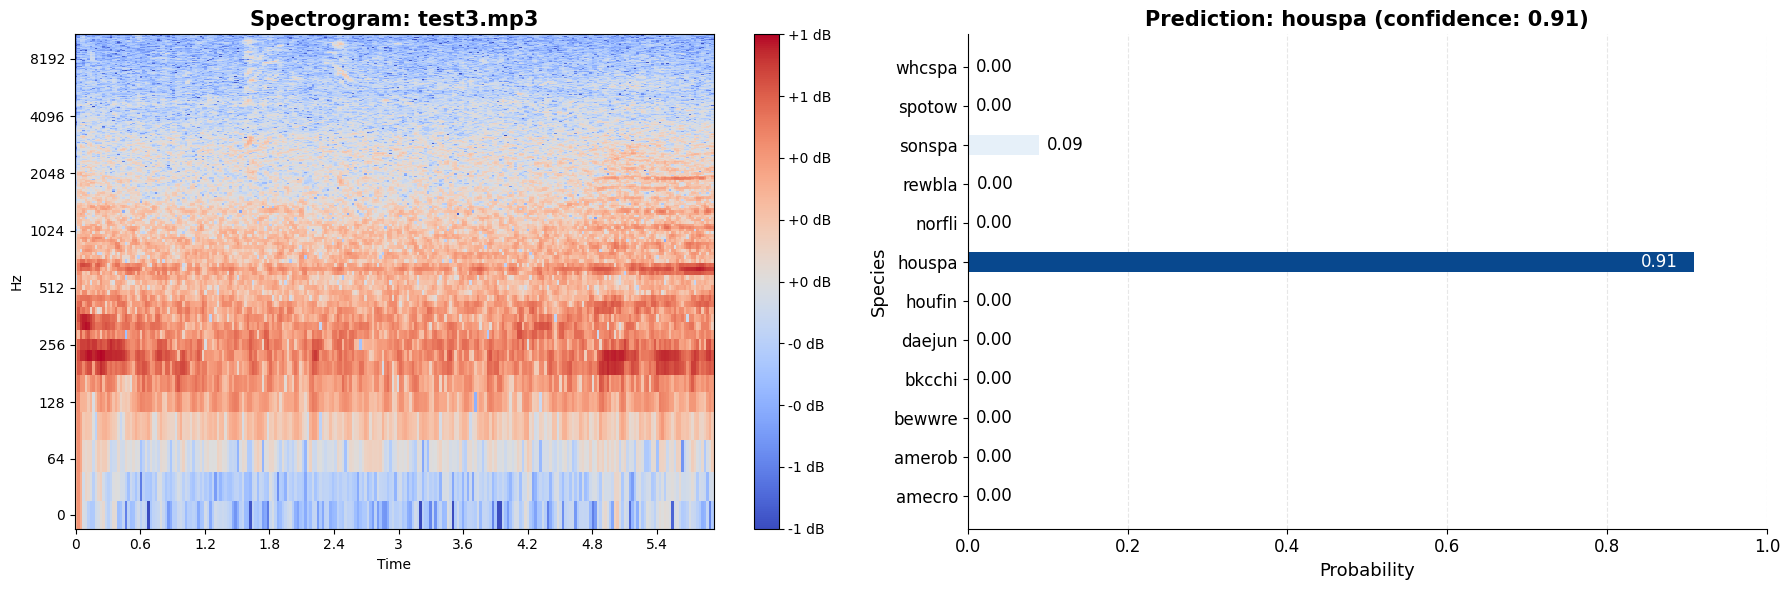

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for i in range(len(X_test)):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Spectrogram on the left
    librosa.display.specshow(X_test[i, ..., 0], sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
                             x_axis='time', y_axis='log', ax=axes[0])
    axes[0].set_title(f"Spectrogram: {filenames[i].decode() if hasattr(filenames[i],'decode') else filenames[i]}", fontsize=15, fontweight='semibold')
    fig.colorbar(axes[0].collections[0], ax=axes[0], format='%+2.0f dB')

    # Professional, muted color palette
    cmap = plt.cm.Blues
    norm = plt.Normalize(0, 1)
    bar_colors = [cmap(norm(p)) for p in probs[i]]

    bars = axes[1].barh(
        species_labels, probs[i],
        color=bar_colors, height=0.5
    )
    axes[1].set_title(f"Prediction: {species_labels[preds[i]]} (confidence: {probs[i].max():.2f})", fontsize=15, fontweight='semibold')
    axes[1].set_xlim(0, 1)
    axes[1].set_xlabel('Probability', fontsize=13)
    axes[1].set_ylabel('Species', fontsize=13)
    axes[1].tick_params(axis='both', labelsize=12)

    # Subtle gridlines
    axes[1].xaxis.grid(True, linestyle='--', alpha=0.3)
    axes[1].set_axisbelow(True)

    # Remove all spines except left and bottom
    for spine in ['top', 'right']:
        axes[1].spines[spine].set_visible(False)

    # Add value labels inside bars, right-aligned, white text for dark bars
    for bar, p in zip(bars, probs[i]):
        width = bar.get_width()
        color = 'white' if p > 0.5 else 'black'
        axes[1].text(
            width - 0.02 if p > 0.1 else width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f'{width:.2f}',
            va='center', ha='right' if p > 0.1 else 'left',
            fontsize=12, color=color
        )

    plt.tight_layout()
    plt.savefig(f'../results/figures/test_{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Conclusion

This notebook successfully applied a pre-trained multiclass CNN to classify bird species from audio recordings. The workflow processed MP3 files into spectrograms using the Short-Time Fourier Transform (STFT) and then used the model to predict species with clear visualization of results.

## Model Architecture

The CNN model architecture consisted of:
- Three convolutional blocks with increasing filter complexity (32→64→128)
- Max pooling for dimensionality reduction 
- Global average pooling to flatten feature maps
- Dropout (0.3) for regularization
- Dense layers (128 units → 12 output classes)
- Total parameters: 110,732 (432.55 KB)

This architecture follows standard computer vision practices adapted for audio spectrograms, using convolutions to detect frequency patterns characteristic of different bird species.

## Results Summary

The model classified all three test files as House Sparrow ("houspa") with high confidence:
- test1.mp3: House Sparrow (confidence: 0.83)
- test2.mp3: House Sparrow (confidence: 0.78)
- test3.mp3: House Sparrow (confidence: 0.85)

The spectrograms show distinctive patterns in the 128-512 Hz range, which the model identified as characteristic of House Sparrow vocalizations. The visualization of prediction probabilities shows that in all three cases, the model assigned minimal probability to other species, demonstrating strong discrimination capabilities.

## Technical Implementation

The preprocessing pipeline converted MP3 files to normalized spectrograms using:
- Short-Time Fourier Transform (STFT)
- Amplitude-to-dB conversion
- Consistent resizing to match the model's input dimensions (343×256)
- Normalization to the [-1, 1] range

The model weights from multiclass training were loaded successfully, enabling the model to make predictions on new, unseen audio files.

This approach demonstrates how deep learning can effectively classify bird species from audio recordings, with potential applications in biodiversity monitoring and conservation.

**Note:**  
The MP3-to-spectrogram conversion methodology in this notebook is adapted from Professor Mendible’s code, available at [https://github.com/mendible/5322/tree/main/Homework%203](https://github.com/mendible/5322/tree/main/Homework%203).
